# Import learning data

In [2]:
import pandas as pd

data_path = "../learning_data/data/win_rate/turn/100-data-100-simulation-2-players-win-rate-data.csv"
df = pd.read_csv(data_path)

# About learning data

In [3]:
df.shape

(100, 13)

In [4]:
df.head()

,hole1,hole2,community1,community2,community3,community4,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id
0,S7,C7,DK,D8,CT,C2,0.61,46,7,26,21,10,2
1,DJ,HK,H6,S3,CQ,HJ,0.74,24,39,32,42,12,37
2,S5,C7,SQ,H6,CQ,H9,0.53,44,7,51,32,12,35
3,S9,S3,D7,C9,H2,D4,0.84,48,42,20,9,28,17
4,DQ,C9,S5,C8,H5,DA,0.57,25,9,44,8,31,14


In [5]:
df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.609500,27.630000,25.040000,28.990000,27.890000,27.240000,25.380000
std,0.193116,14.646443,16.172005,14.276133,15.051357,16.286649,15.348991
min,0.260000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.477500,18.750000,10.000000,20.000000,13.750000,11.750000,13.500000
50%,0.590000,27.000000,25.000000,30.500000,32.000000,27.500000,24.500000
75%,0.755000,40.000000,39.000000,40.250000,40.250000,41.250000,38.250000
max,1.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000


# Data Processing

## card id -> 1-hot vector

In [6]:
import numpy as np

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
fetch_hole = lambda row: [row[key] for key in ['hole1_id', 'hole2_id']]
fetch_community = lambda row: [row[key] for key in ['community1_id', 'community2_id', 'community3_id', 'community4_id']]
hole_one_hot = df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
community_one_hot = df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
df["onehot"] = hole_one_hot + community_one_hot

## Separate data for training and validation

In [7]:
validation_rate = 0.1
boundary_idx = int(df.shape[0]*(1-validation_rate))
train_df = df[:boundary_idx]
validation_df = df[boundary_idx:]

## Format data (pandas.df -> numpy.ndarray)

In [8]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
val_x, val_y = [to_ndarray(array) for array in [validation_df["onehot"].values, validation_df["win_rate"].values]]
print "shape of training x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of validation x: %s, y: %s" % (val_x.shape, val_y.shape)

shape of training x: (90, 104), y: (90,)
shape of validation x: (10, 104), y: (10,)


# Create model

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=104))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

Using Theano backend.


# Train model

In [12]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=100, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

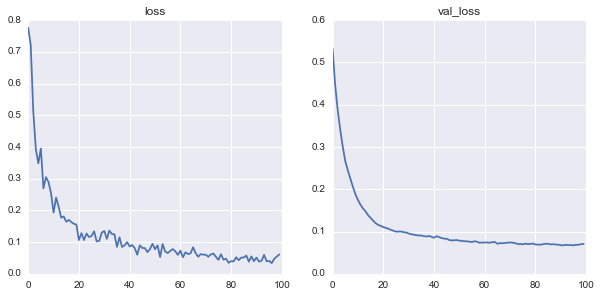

In [13]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [14]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, val_x, val_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on validation data = {score}'.format(score=mean_squared_error(model.predict(val_x), val_y))

In [15]:
print_model_performance(model, train_x, train_y, val_x, val_y)

MSE on training data = 0.0112755758322
MSE on validation data = 0.077101111736


## See model prediction on sample data

In [21]:
from pypokerengine.engine.card import Card
C, D, H, S = Card.CLUB, Card.DIAMOND, Card.HEART, Card.SPADE

test_case = [
    [(8, D), (4, C), (13, C), (1, C), (6, C), (2, C), 0.994],
    [(3, D), (3, H), (5, H), (4, D), (5, S), (4, H), 0.11],
    [(1, C), (10, D), (6, H), (9, H), (8, D), (11, C), 0.505]
]

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
to_id = lambda card: card.to_id()

for card1, card2, card3, card4, card5, card6, expected in test_case:
    cards = [Card(rank=rank, suit=suit) for rank, suit in [card1, card2, card3, card4, card5, card6]]
    hole = cards[:2]
    community = cards[2:]
    hole_onehot = gen_one_hot(map(to_id, hole))
    community_onehot = gen_one_hot(map(to_id, community))
    x = hole_onehot + community_onehot
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s], COMMUNITY = [%s, %s, %s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole) + map(str, community) + [y , expected])

HOLE = [D8, C4], COMMUNITY = [CK, CA, C6, C2] => win_rate = { prediction=0.388259, expected=0.994000 }
HOLE = [D3, H3], COMMUNITY = [H5, D4, S5, H4] => win_rate = { prediction=0.631517, expected=0.110000 }
HOLE = [CA, DT], COMMUNITY = [H6, H9, D8, CJ] => win_rate = { prediction=0.401906, expected=0.505000 }
